In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal

In [2]:
def gcc(sig, refsig, method="PHAT", interp=1):

    assert method in ["PHAT", "CC"]
    
    n = sig.shape[0] + refsig.shape[0]
    
    SIG = np.fft.rfft(sig, n=n)         
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)
    
    if method == "PHAT":
        ccf = np.fft.irfft(R / np.abs(R), n=(interp * n)) # discard the ampltude and keep the phase
    elif method == "CC":
        ccf = np.fft.irfft(R, n=(interp * n))             # standard cross-correlation
    
    max_shift = int(interp * n / 2)

    ccf = np.concatenate((ccf[-max_shift:], ccf[:max_shift+1]))

    shift = np.argmax(np.abs(ccf)) - max_shift
    return shift, ccf, max_shift

In [3]:
def read_audio(filename):
    #     Inputs:
    #            filename - audio filename
    #     Output:
    #            seq      - chirp sequence
    
    fs, voice  = wavfile.read(filename)
    #voice.shape
    voice = voice.astype(np.float32)
    voice = voice / np.max(voice)
    
    return voice

def generate_chirp(N, f0, f1, fs):
    #     Inputs:
    #             N     -  sequence length in samples
    #             f0    -  starting frequency 
    #             f1    -  end frequency
    #             fs    -  sampling frequency
    #     Output:
    #              seq - chirp sequence
    
    duration = N / float(fs)
    t = np.arange(N) / float(fs)
    k = (f1 - f0) / duration
    phase = 2 * np.pi * (f0 + k/2 * t) * t
    
    seq = np.exp(1j * phase)
    seq = seq.real  # for simplicy, we only keep the real part
    
    return seq

def generate_ZC(N, u=63, q=1):
    #     Inputs:
    #             N   -  sequence length in samples
    #             u   -  ZC parameter
    #             q   -  constant integer
    #     Output:
    #              seq - ZC sequence

    seq = []
    for n in range(N):
        phase = -1j *  np.pi*u*n*(n+1+2*q) / N
        seq.append(np.exp(phase)) 

    seq = np.array(seq)
    seq = seq.real  # for simplicy, we only keep the real part.
    
    return seq

def generate_PN(N):
    #     Inputs:
    #             N   - sequence length in samples
    #     Output:
    #             seq - PN sequence
    
    seq = []
    for n in range(N):
        seq.append(np.random.randn())
    seq = np.array(seq)
    
    return seq

In [4]:
def plot_gcc(frame0, frame1, method="PHAT",):
    
    plt.rcParams["font.family"] = "Times New Roman"
    fontsize = 20
    
    shift, cc, max_shift = gcc(frame0, frame1, method=method)
    cc = abs(cc)
    cc = cc / np.max(cc)
    
    plt.figure()
    plt.plot(np.arange(len(cc)) - max_shift, cc, '-', c="#4d4d4d")
    
    plt.ylabel("Cor.", fontsize=fontsize)
    plt.xlabel("Time shift [Sample]", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlim([-127, 127])
    
    
    peak_idxs, properties = signal.find_peaks(cc,  height=np.max(cc)*0.1)
    plt.plot(np.array(peak_idxs) - max_shift, cc[peak_idxs], '^', color='orange')
        
    plt.legend([method], fontsize=fontsize)
    plt.tight_layout()

## Auto-correlation of voice

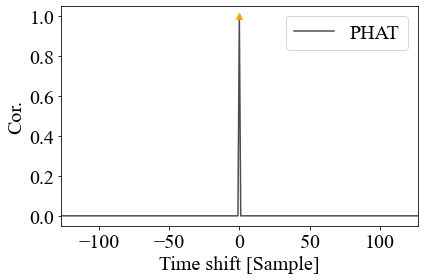

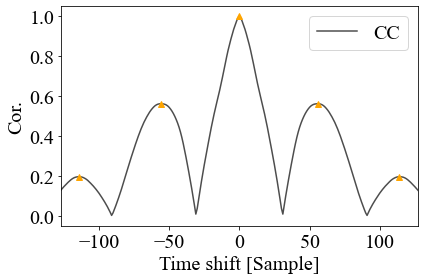

In [5]:
voice = read_audio("./voa.wav")
plot_gcc(voice, voice, method="PHAT")
plt.savefig("./figures/voice_phat.jpg")
plot_gcc(voice, voice, method="CC")
plt.savefig("./figures/voice_cc.jpg")

## Auto-correlation of ZC sequence

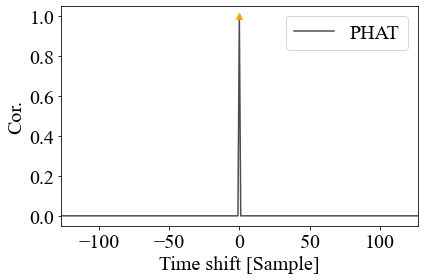

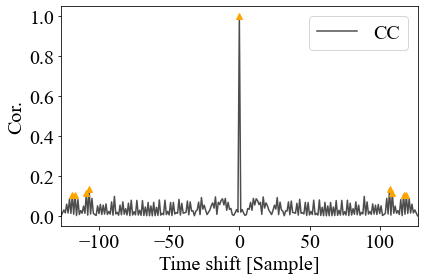

In [6]:
N = 127
ZC_seq = generate_ZC(N)
plot_gcc(ZC_seq, ZC_seq, method="PHAT")
plt.savefig("./figures/ZC_phat.jpg")
plot_gcc(ZC_seq, ZC_seq, method="CC")
plt.savefig("./figures/ZC_cc.jpg")

## Auto-correlation of PN sequence

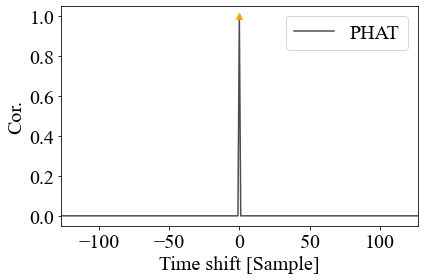

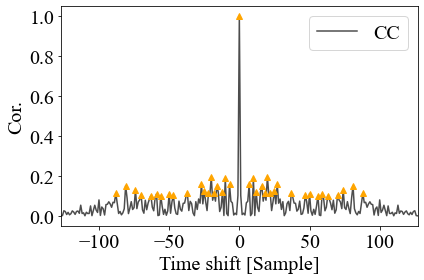

In [7]:
N = 127
PN_seq = generate_PN(N)
plot_gcc(PN_seq, PN_seq, method="PHAT")
plt.savefig("./figures/PN_phat.jpg")
plot_gcc(PN_seq, PN_seq, method="CC")
plt.savefig("./figures/PN_cc.jpg")

## Auto-correaltion of Chirp sequence

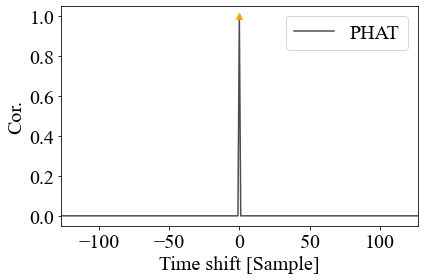

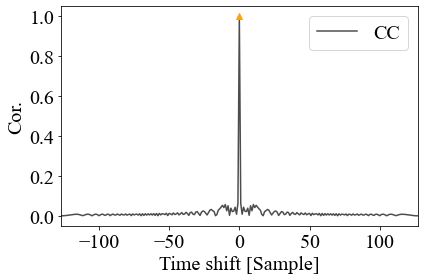

In [8]:
N = 127
chirp_seq = generate_chirp(N, 0, 24000, 48000)
plot_gcc(chirp_seq, chirp_seq, method="PHAT")
plt.savefig("./figures/chirp_phat.jpg")
plot_gcc(chirp_seq, chirp_seq, method="CC")
plt.savefig("./figures/chirp_cc.jpg")